In [1]:
import pandas as pd
import geopandas as gpd
import sys
import matplotlib.pyplot as plt 
import seaborn as sns
import rasterio as rio
from rasterio.plot import plotting_extent
import earthpy.plot as ep
import numpy as np
from rasterstats import zonal_stats
import functools as ft
import warnings

warnings.simplefilter(action='ignore', category=UserWarning)
dir_path = './data/raw/'

In [2]:
%%time
# schools 
schools =  gpd.read_file(dir_path+'Education_Facilities.geojson')
# village boundaries
village_boundaries = gpd.read_file(dir_path+'Villages_boundaries.geojson')
# district boundaries
district_boundaries = gpd.read_file(dir_path+'District_Boundaries.geojson')

CPU times: user 13.5 s, sys: 212 ms, total: 13.8 s
Wall time: 14.1 s


In [3]:
# convert to lowercase
village_cols = ['district','sector_1','village']
for col in village_cols:
    village_boundaries[col] = village_boundaries[col].str.lower()
school_cols = ['district','sector','cell','school_nam']   
for col in school_cols:
     schools[col] = schools[col].str.lower()
        
# Identify unique villages
village_boundaries['unique_village'] = village_boundaries['district']+'_'+village_boundaries['sector_1']+'_'+village_boundaries['village']


In [4]:
# group by village
schools_w_villages = schools.sjoin(village_boundaries[['unique_village','geometry']])
school_counts = schools_w_villages.groupby(['unique_village'])['globalid'].count().reset_index().rename(
    columns={'globalid':'school_count'})

In [6]:
school_counts.school_count.sum()

3317

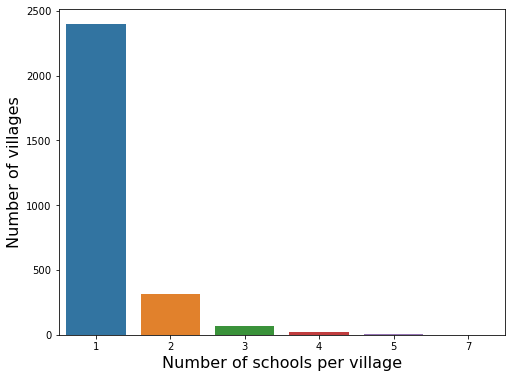

In [7]:
fig, ax = plt.subplots(1, figsize=(8, 6))
sns.countplot(ax=ax,data=school_counts, x="school_count")
plt.ylabel('Number of villages', fontsize=16)
plt.xlabel('Number of schools per village', fontsize=16)
plt.show()

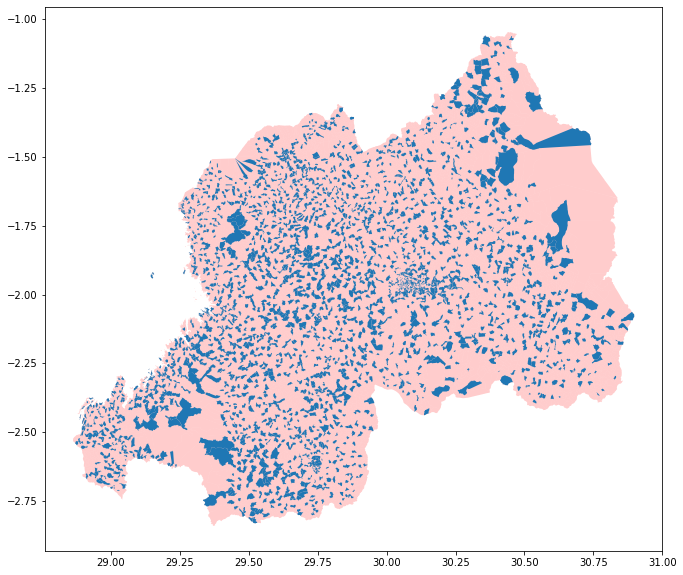

In [8]:
# spatial distribution building footprints in rwanda by village
village_sch_count = village_boundaries.merge(school_counts, how='left', on='unique_village')
fig, ax = plt.subplots(1, figsize=(20, 10))
village_boundaries.plot(ax=ax,color='red',alpha=0.2)
# village_sch_count.plot(ax=ax, column='school_count', legend=True)
village_sch_count[village_sch_count.school_count.notna()].plot(ax=ax,)
# schools.plot(ax=ax,markersize=1)
plt.show()

## Health Facilities

In [7]:
# Health centers facilities
health_centres =  gpd.read_file(dir_path+ 'Health_Facilities.geojson')

In [8]:
# group by village
health_centres_w_villages = health_centres.sjoin(village_boundaries[['code_vill_','geometry']])
health_centres_counts = health_centres_w_villages.groupby(['code_vill_'])['globalid'].count().reset_index().rename(
    columns={'globalid':'health_centres_count'})

In [13]:
health_centres_w_villages.layer.value_counts()

HEALTH CENTRE          500
Health post            470
Family Health Posts     56
DISTRICT HOSPITAL       35
REFERENCE HOSPITAL       9
PROVINCIAL HOSPITAL      4
Name: layer, dtype: int64

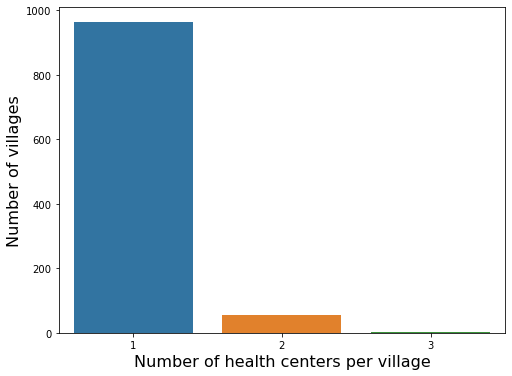

In [13]:
fig, ax = plt.subplots(1, figsize=(8, 6))
sns.countplot(ax=ax,data=health_centres_counts, x="health_centres_count")
plt.ylabel('Number of villages', fontsize=16)
plt.xlabel('Number of health centers per village', fontsize=16)
plt.show()

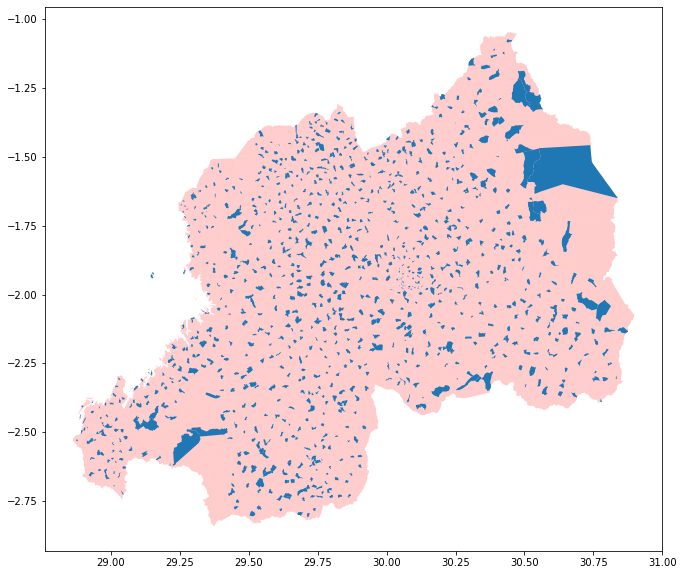

In [15]:
# spatial distribution building footprints in rwanda by village
village_health_centres_counts = village_boundaries.merge(health_centres_counts, how='left', on='code_vill_')
fig, ax = plt.subplots(1, figsize=(20, 10))
village_boundaries.plot(ax=ax,color='red',alpha=0.2)
village_health_centres_counts[village_health_centres_counts.health_centres_count.notna()].plot(ax=ax,)
# health_centres.plot(ax=ax,markersize=1)
plt.show()

## Trade Centers

In [87]:
# Trade centers facilities 
trade_centres =  gpd.read_file(dir_path+ 'Trade_centers.geojson')


In [23]:
trade_centres['type'].shape

(451,)

In [92]:
# group by village
trade_centres_w_villages = trade_centres.sjoin(village_boundaries[['unique_village','geometry']])
trade_centres_counts = trade_centres_w_villages.groupby(['unique_village'])['globalid'].count().reset_index().rename(
    columns={'globalid':'trade_centres_count'})

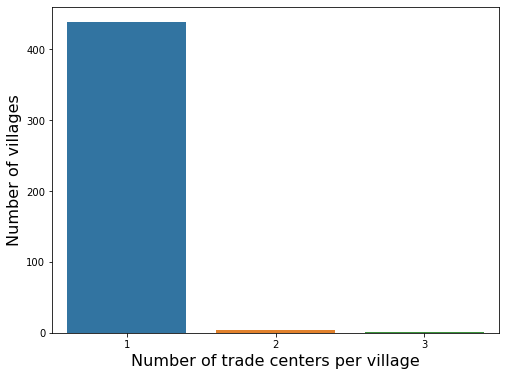

In [93]:
fig, ax = plt.subplots(1, figsize=(8, 6))
sns.countplot(ax=ax,data=trade_centres_counts, x="trade_centres_count")
plt.ylabel('Number of villages', fontsize=16)
plt.xlabel('Number of trade centers per village', fontsize=16)
plt.show()

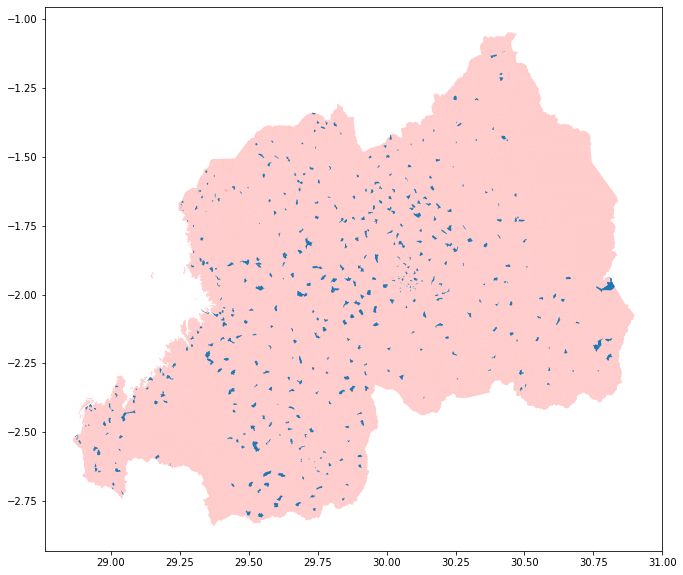

In [94]:
# spatial distribution building footprints in rwanda by village
village_trade_centres_counts = village_boundaries.merge(trade_centres_counts, how='left', on='unique_village')
fig, ax = plt.subplots(1, figsize=(20, 10))
village_boundaries.plot(ax=ax,color='red',alpha=0.2)
village_trade_centres_counts[village_trade_centres_counts.trade_centres_count.notna()].plot(ax=ax,)
# trade_centres.plot(ax=ax,markersize=1)
plt.show()

## coffee washing

In [24]:
# Coffee centers facilities 
coffee_centres =  gpd.read_file(dir_path+ 'Coffee_Washing_Stations.geojson')

In [26]:
coffee_centres.shape

(207, 21)

In [18]:
coffee_cols = ['district','sector','cell']   
for col in coffee_cols:
     coffee_centres[col] = coffee_centres[col].str.lower()
# Identify unique coffee center
coffee_centres['unique_center'] = coffee_centres['x'].astype(str)+'_'+coffee_centres['y'].astype(str)

In [19]:
# group by village
coffee_centres_w_villages = coffee_centres.sjoin(village_boundaries[['unique_village','geometry']])
coffee_centres_counts = coffee_centres_w_villages.groupby(['unique_village'])['unique_center'].count().reset_index().rename(
    columns={'globalid':'coffee_centres_count'})

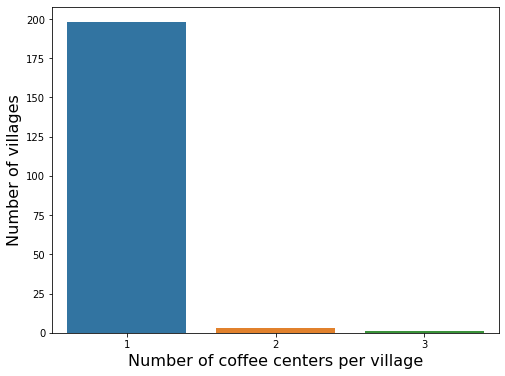

In [20]:
fig, ax = plt.subplots(1, figsize=(8, 6))
sns.countplot(ax=ax,data=coffee_centres_counts, x="unique_center")
plt.ylabel('Number of villages', fontsize=16)
plt.xlabel('Number of coffee centers per village', fontsize=16)
plt.show()

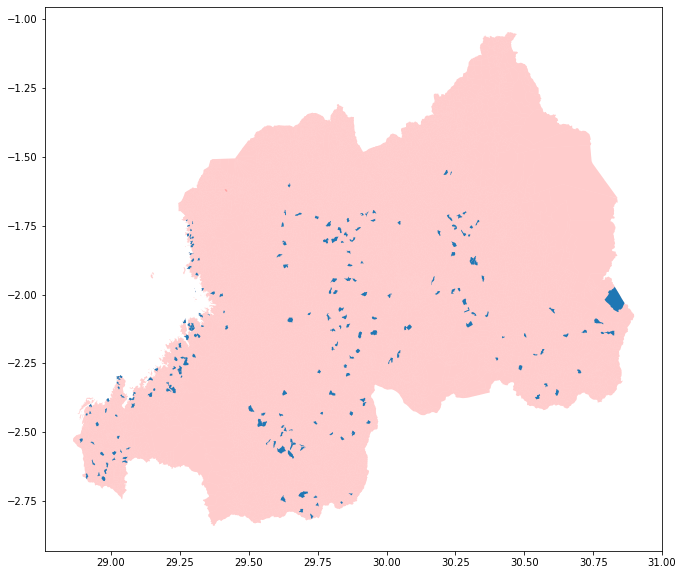

In [21]:
# spatial distribution building footprints in rwanda by village
village_coffee_centres_counts = village_boundaries.merge(coffee_centres_counts, how='left', on='unique_village')
fig, ax = plt.subplots(1, figsize=(20, 10))
village_boundaries.plot(ax=ax,color='red',alpha=0.2)
village_coffee_centres_counts[village_coffee_centres_counts.unique_center.notna()].plot(ax=ax,)
# coffee_centres.plot(ax=ax,markersize=1)
plt.show()

## Tourism

In [122]:
# tourism centers facilities 
tourism_centres =  gpd.read_file(dir_path+ 'Tourism_POI.geojson')
# create unique ids
tourism_centres['unique_center'] = tourism_centres.geometry.to_wkt()

In [23]:
# group by village
tourism_centres_w_villages = tourism_centres.sjoin(village_boundaries[['unique_village','geometry']])
tourism_centres_counts = tourism_centres_w_villages.groupby(['unique_village'])['unique_center'].count().reset_index().rename(
    columns={'globalid':'tourism_centres_count'})

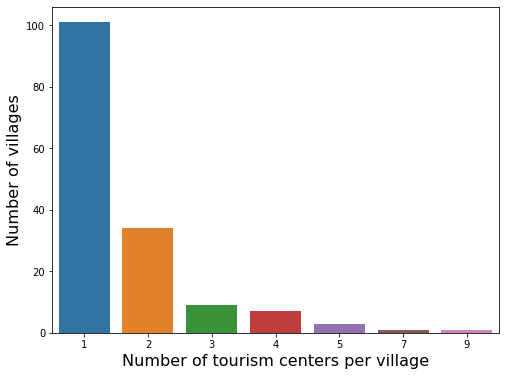

In [24]:
fig, ax = plt.subplots(1, figsize=(8, 6))
sns.countplot(ax=ax,data=tourism_centres_counts, x="unique_center")
plt.ylabel('Number of villages', fontsize=16)
plt.xlabel('Number of tourism centers per village', fontsize=16)
plt.show()

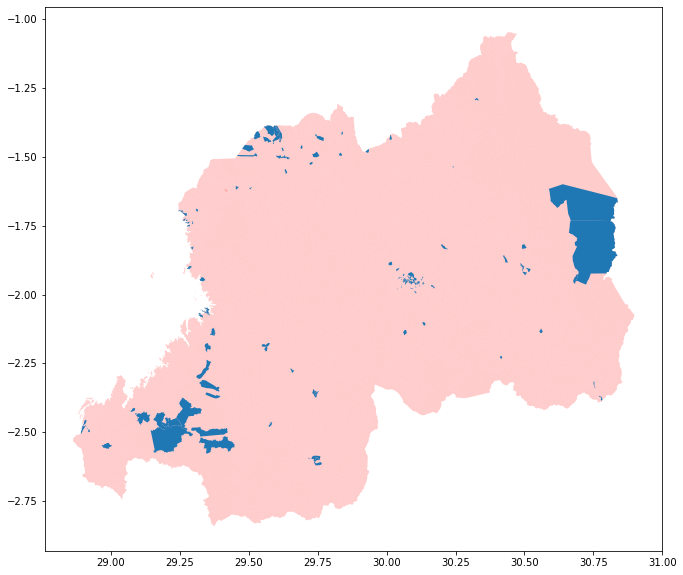

In [25]:
# spatial distribution building footprints in rwanda by village
village_tourism_centres_counts = village_boundaries.merge(tourism_centres_counts, how='left', on='unique_village')
fig, ax = plt.subplots(1, figsize=(20, 10))
village_boundaries.plot(ax=ax,color='red',alpha=0.2)
village_tourism_centres_counts[village_tourism_centres_counts.unique_center.notna()].plot(ax=ax,)
# tourism_centres.plot(ax=ax,markersize=1)
plt.show()

## Religious centers

In [29]:
# religious centers facilities 
religious_centres =  gpd.read_file(dir_path+ 'Religious_Facilities.geojson')
# create unique ids
religious_centres['unique_center'] = religious_centres.geometry.to_wkt()

In [30]:
# group by village
religious_centres_w_villages = religious_centres.sjoin(village_boundaries[['unique_village','geometry']])
religious_centres_counts = religious_centres_w_villages.groupby(['unique_village'])['unique_center'].count().reset_index().rename(
    columns={'globalid':'religious_centres_count'})

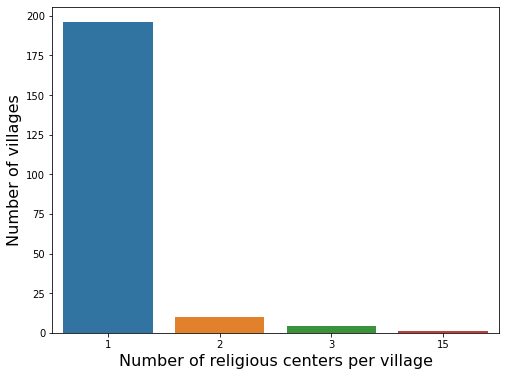

In [31]:
fig, ax = plt.subplots(1, figsize=(8, 6))
sns.countplot(ax=ax,data=religious_centres_counts, x="unique_center")
plt.ylabel('Number of villages', fontsize=16)
plt.xlabel('Number of religious centers per village', fontsize=16)
plt.show()

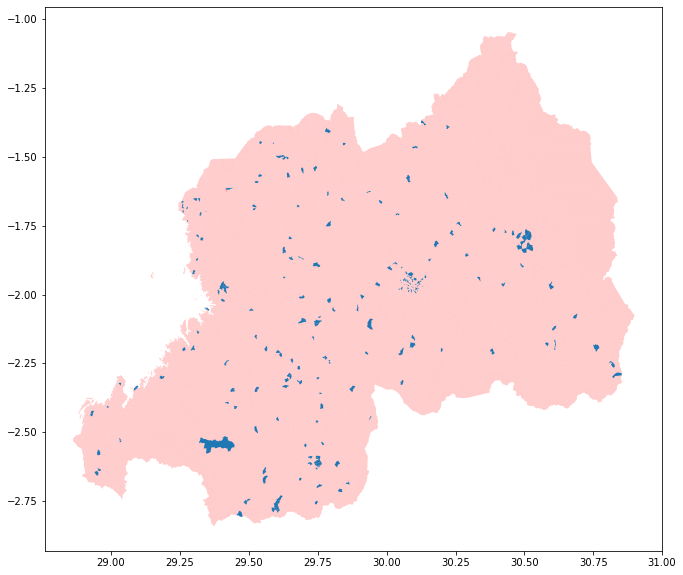

In [32]:
# spatial distribution building footprints in rwanda by village
village_religious_centres_counts = village_boundaries.merge(religious_centres_counts, how='left', on='unique_village')
fig, ax = plt.subplots(1, figsize=(20, 10))
village_boundaries.plot(ax=ax,color='red',alpha=0.2)
village_religious_centres_counts[village_religious_centres_counts.unique_center.notna()].plot(ax=ax,)
# religious_centres.plot(ax=ax,markersize=1)
plt.show()

## sports

In [33]:
# sports centers facilities 
sports_centres =  gpd.read_file(dir_path+ 'Sports.geojson')
# create unique ids
sports_centres['unique_center'] = sports_centres.geometry.to_wkt()

In [34]:
# group by village
sports_centres_w_villages = sports_centres.sjoin(village_boundaries[['unique_village','geometry']])
sports_centres_counts = sports_centres_w_villages.groupby(['unique_village'])['unique_center'].count().reset_index().rename(
    columns={'globalid':'sports_centres_count'})

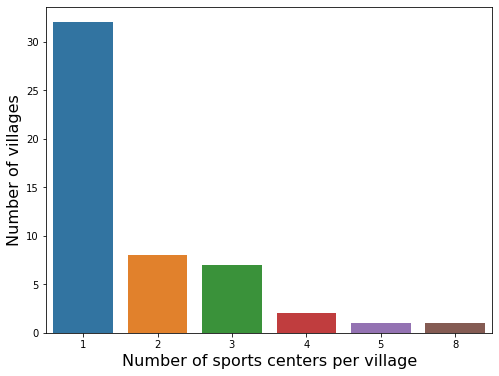

In [35]:
fig, ax = plt.subplots(1, figsize=(8, 6))
sns.countplot(ax=ax,data=sports_centres_counts, x="unique_center")
plt.ylabel('Number of villages', fontsize=16)
plt.xlabel('Number of sports centers per village', fontsize=16)
plt.show()

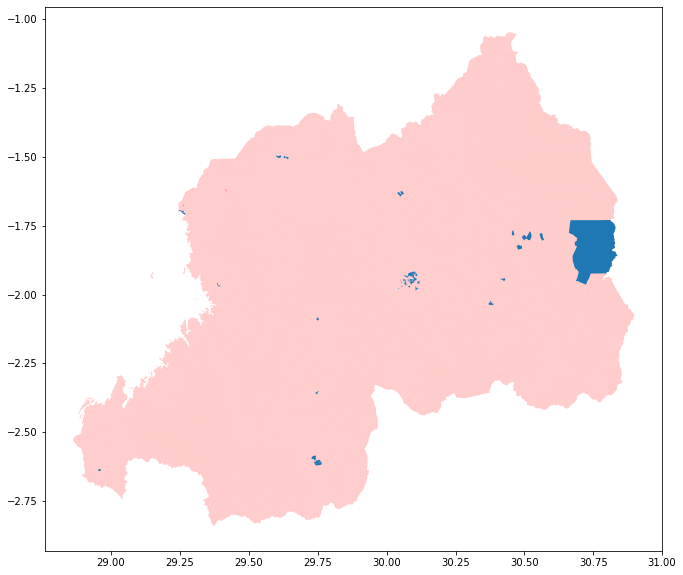

In [36]:
# spatial distribution building footprints in rwanda by village
village_sports_centres_counts = village_boundaries.merge(sports_centres_counts, how='left', on='unique_village')
fig, ax = plt.subplots(1, figsize=(20, 10))
village_boundaries.plot(ax=ax,color='red',alpha=0.2)
village_sports_centres_counts[village_sports_centres_counts.unique_center.notna()].plot(ax=ax,)
# sports_centres.plot(ax=ax,markersize=1)
plt.show()

0,0
0,1
0,2
1,0
1,1
1,2


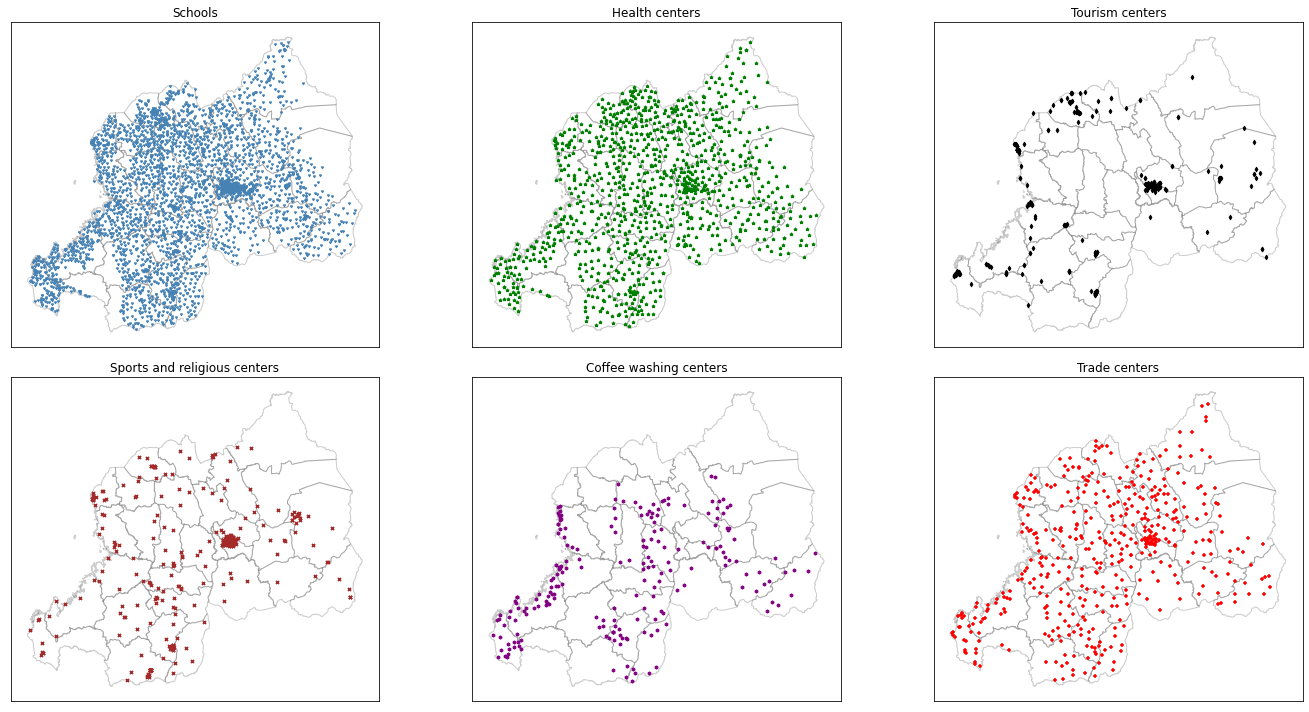

In [194]:

f, axes = plt.subplots(figsize=(20, 10), ncols=3, nrows=2)
# schools
district_boundaries.plot(ax=axes[0,0],color='white',edgecolor='black',alpha=0.2, figsize=(5,5))
schools.plot(ax=axes[0,0],markersize=10, marker='1', color='steelblue', figsize=(5,5))
axes[0][0].set_title('Schools')

# Health centers
district_boundaries.plot(ax=axes[0][1],color='white',edgecolor='black',alpha=0.2)
health_centres.plot(ax=axes[0][1],markersize=10, marker='*', color='green')
axes[0][1].set_title('Health centers')

# sports and religion
district_boundaries.plot(ax=axes[1][0],color='white',edgecolor='black',alpha=0.2)
sports_centres.plot(ax=axes[1][0], markersize=10, marker='x', color='brown')
religious_centres.plot(ax=axes[1][0], markersize=10, marker='x', color='brown')
axes[1][0].set_title('Sports and religious centers')

# coffee centers
district_boundaries.plot(ax=axes[1][1],color='white',edgecolor='black',alpha=0.2)
coffee_centres.plot(ax=axes[1][1], markersize=10, marker='h', color='purple')
axes[1][1].set_title('Coffee washing centers')

# Tourism centers
district_boundaries.plot(ax=axes[0][2],color='white',edgecolor='black',alpha=0.2)
tourism_centres.plot(ax=axes[0][2], markersize=10, marker='d', color='black')
axes[0][2].set_title('Tourism centers')

# Trade centers
district_boundaries.plot(ax=axes[1][2],color='white',edgecolor='black',alpha=0.2)
trade_centres.drop(445, axis=0).plot(ax=axes[1][2],markersize=10, marker='+', color='red')
axes[1][2].set_title('Trade centers')

for i in range(0,2):
    for j in range(0,3):        
        axes[i][j].set_yticklabels([])
        axes[i][j].set_xticklabels([])
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])

plt.tight_layout()
plt.show()

## Landcover

### 2015 landcover

In [15]:
# import tif file
fp_2015 = 'rwanda_landcover_2015_scheme_i.tif'

with rio.open(dir_path+fp_2015) as dataset:
    array_2015 = dataset.read(1)
    crs_2015 = dataset.crs
    array_ext_2015 = plotting_extent(dataset)
    nodata_2015 = dataset.nodata
    array_2015 = np.where(array_2015 == nodata_2015, np.nan, array_2015)
    array_2015 = np.where(array_2015 == 0, np.nan, array_2015)
    transform_2015 = dataset.transform
    shape_2015 = dataset.shape
    units   = dataset.resolution()
print(units)

AttributeError: 'DatasetReader' object has no attribute 'resolution'

In [16]:
transform_2015

Affine(0.0002706990285570464, 0.0, 28.83839783874783,
       0.0, -0.00027069902855704654, -1.0175032870665)

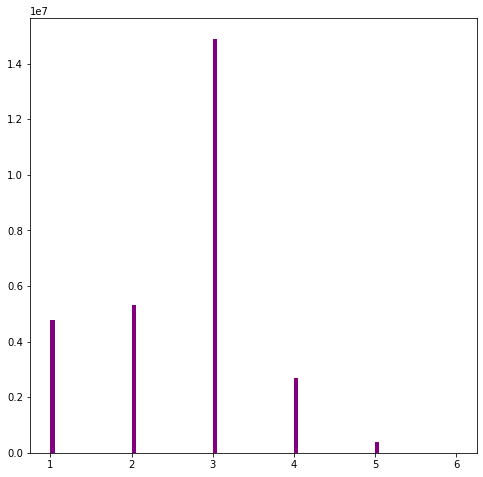

In [18]:
ep.hist(array_2015, figsize=(8, 8), bins=100)
plt.show()

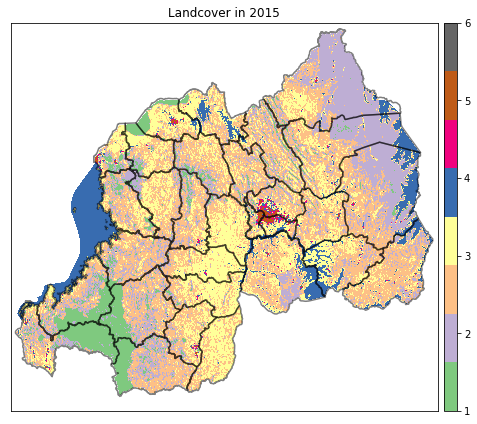

CPU times: user 5.22 s, sys: 1.35 s, total: 6.57 s
Wall time: 6.58 s


In [198]:
%%time
fig, ax = plt.subplots(1, figsize = (8, 8))
image_hidden = ep.plot_bands(array_2015,
              cmap='Accent',
              extent=array_ext_2015,
              cbar=True,
             ax=ax,)
district_boundaries.boundary.plot( ax=ax, color='black', alpha=0.5)
ax.set_title('Landcover in 2015')
plt.show()

In [20]:
%%time

villages = 'Villages_boundaries.geojson'
stats = zonal_stats(dir_path+villages,
                     dir_path+fp_2015,
                   geojson_out=True,
                    categorical=True,
                    stats='majority'
                   )
village_landcover_2015 = []
for i in range(0,len(stats)):
    landcover_list = []
    for key, value in stats[i]['properties'].items():
        
        if key == 'code_vill_':
            village_code= value
        if key == 'majority':
            village_majority = value
        if isinstance(key,int):
            landcover = {key:value}
            landcover_list.append(landcover)
    village_landcover_2015.append({village_code:[village_majority,landcover_list]})

CPU times: user 58 s, sys: 12.3 s, total: 1min 10s
Wall time: 1min 10s


In [205]:
%%time
index = village_boundaries.code_vill_.tolist()
df_2015 = pd.DataFrame(np.nan, index=index, columns=['village_id','majority', '1', '2', '3', '4', '5', '6'])
for i in range(0,len(village_landcover_2015)):

    for i_d, val_list in (village_landcover_2015[i].items()):
        df_2015.loc[i_d,'village_id'] = i_d
        df_2015.loc[i_d,'majority'] = val_list[0]
        for dict_item in val_list[1]:          
            for key,value in dict_item.items():
                if key==1:
                    df_2015.loc[i_d,'1']=value
                if key==2:
                    df_2015.loc[i_d,'2']=value        
                if key==3:
                    df_2015.loc[i_d,'3']=value
                if key==4:
                    df_2015.loc[i_d,'4']=value            
                if key==5:
                    df_2015.loc[i_d,'5']=value            
                if key==6:
                    df_2015.loc[i_d,'6']=value            
df_2015['total_pixel_count'] = df_2015[['1', '2', '3', '4', '5', '6']].sum(axis=1)  
df_2015['Forestland_2015'] = round(df_2015['1']/df_2015['total_pixel_count']*100,1)
df_2015['Grassland_2015']  = round(df_2015['2']/df_2015['total_pixel_count']*100,1)
df_2015['Cropland_2015']   = round(df_2015['3']/df_2015['total_pixel_count']*100,1)
df_2015['Wetland_2015']    = round(df_2015['4']/df_2015['total_pixel_count']*100,1)
df_2015['Settlement_2015'] = round(df_2015['5']/df_2015['total_pixel_count']*100,1)
df_2015['Otherland_2015']  = round(df_2015['6']/df_2015['total_pixel_count']*100,1)

NameError: name 'village_landcover_2015' is not defined

In [22]:
df_2015.head()

,village_id,majority,1,2,3,4,5,6,total_pixel_count,Forestland_2015,Grassland_2015,Cropland_2015,Wetland_2015,Settlement_2015,Otherland_2015
11010102,11010102.0,5.0,NaN,NaN,NaN,NaN,31.0,NaN,31.0,NaN,NaN,NaN,NaN,100.0,NaN
11010103,11010103.0,5.0,2.0,NaN,NaN,NaN,80.0,NaN,82.0,2.4,NaN,NaN,NaN,97.6,NaN
11010104,11010104.0,5.0,NaN,NaN,NaN,NaN,15.0,NaN,15.0,NaN,NaN,NaN,NaN,100.0,NaN
11010105,11010105.0,5.0,NaN,NaN,NaN,NaN,36.0,NaN,36.0,NaN,NaN,NaN,NaN,100.0,NaN
11010106,11010106.0,5.0,NaN,NaN,NaN,NaN,14.0,NaN,14.0,NaN,NaN,NaN,NaN,100.0,NaN


### 2010 landcover

In [93]:
# import tif file
fp_2010 = '/raw/nelga_land_cover/2010/Rwanda_Landcover_2010_Scheme_I.tif'

with rio.open(dir_path+fp_2010) as dataset:
    array_2010 = dataset.read(1)
    crs_2010 = dataset.crs
    array_ext_2010 = plotting_extent(dataset)
    nodata_2010 = dataset.nodata
    array_2010 = np.where(array_2010 == nodata, np.nan, array_2010)
    array_2010 = np.where(array_2010 == 0, np.nan, array_2010)
    transform_2010 = dataset.transform
    shape_2010 = dataset.shape

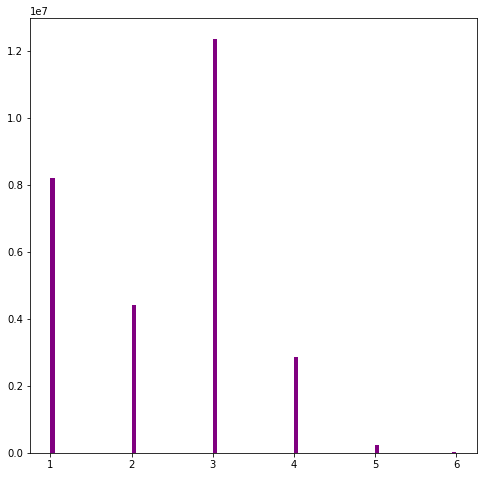

In [94]:
ep.hist(array_2010, figsize=(8, 8), bins=100)
plt.show()

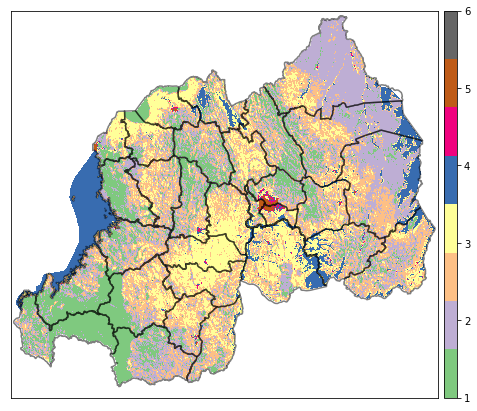

CPU times: user 5.25 s, sys: 1.8 s, total: 7.05 s
Wall time: 6.71 s


In [95]:
%%time
fig, ax = plt.subplots(1, figsize = (8, 8))
image_hidden = ep.plot_bands(array_2010,
              cmap='Accent',
              extent=array_ext_2010,
              cbar=True,
             ax=ax,)
district_boundaries.boundary.plot( ax=ax, color='black', alpha=0.5)
plt.show()

In [96]:
%%time

villages = '/raw/nisr_administrative boundaries/Villages_boundaries.geojson'
districts = '/raw/nisr_administrative boundaries/district_boundaries.geojson'
stats = zonal_stats(dir_path+villages,
                     dir_path+fp_2010,
                   geojson_out=True,
                    categorical=True,
                    stats='majority'
                   )
village_landcover_2010 = []
for i in range(0,len(stats)):
    landcover_list = []
    for key, value in stats[i]['properties'].items():
        
        if key == 'code_vill_':
            village_code= value
        if key == 'majority':
            village_majority = value
        if isinstance(key,int):
            landcover = {key:value}
            landcover_list.append(landcover)
    village_landcover_2010.append({village_code:[village_majority,landcover_list]})

CPU times: user 1min 9s, sys: 12.6 s, total: 1min 22s
Wall time: 2min 29s


In [98]:
%%time
index = village_boundaries.code_vill_.tolist()
df_2010 = pd.DataFrame(np.nan, index=index, columns=['village_id','majority', '1', '2', '3', '4', '5', '6'])
for i in range(0,len(village_landcover_2010)):

    for i_d, val_list in (village_landcover_2010[i].items()):
        df_2010.loc[i_d,'village_id'] = i_d
        df_2010.loc[i_d,'majority'] = val_list[0]
        for dict_item in val_list[1]:          
            for key,value in dict_item.items():
                if key==1:
                    df_2010.loc[i_d,'1']=value
                if key==2:
                    df_2010.loc[i_d,'2']=value        
                if key==3:
                    df_2010.loc[i_d,'3']=value
                if key==4:
                    df_2010.loc[i_d,'4']=value            
                if key==5:
                    df_2010.loc[i_d,'5']=value            
                if key==6:
                    df_2010.loc[i_d,'6']=value            
df_2010['total_pixel_count'] = df_2010[['1', '2', '3', '4', '5', '6']].sum(axis=1)  
df_2010['Forestland_2010'] = round(df_2010['1']/df_2010['total_pixel_count']*100,1)
df_2010['Grassland_2010']  = round(df_2010['2']/df_2010['total_pixel_count']*100,1)
df_2010['Cropland_2010']   = round(df_2010['3']/df_2010['total_pixel_count']*100,1)
df_2010['Wetland_2010']    = round(df_2010['4']/df_2010['total_pixel_count']*100,1)
df_2010['Settlement_2010'] = round(df_2010['5']/df_2010['total_pixel_count']*100,1)
df_2010['Otherland_2010']  = round(df_2010['6']/df_2010['total_pixel_count']*100,1)

CPU times: user 3.39 s, sys: 21.8 ms, total: 3.42 s
Wall time: 3.43 s


In [99]:
df_2010.head()

,village_id,majority,1,2,3,4,5,6,total_pixel_count,Forestland_2010,Grassland_2010,Cropland_2010,Wetland_2010,Settlement_2010,Otherland_2010
11010102,11010102.0,5.0,NaN,NaN,NaN,NaN,28.0,NaN,28.0,NaN,NaN,NaN,NaN,100.0,NaN
11010103,11010103.0,5.0,NaN,NaN,NaN,NaN,84.0,NaN,84.0,NaN,NaN,NaN,NaN,100.0,NaN
11010104,11010104.0,5.0,NaN,NaN,NaN,NaN,14.0,NaN,14.0,NaN,NaN,NaN,NaN,100.0,NaN
11010105,11010105.0,5.0,NaN,NaN,NaN,NaN,36.0,NaN,36.0,NaN,NaN,NaN,NaN,100.0,NaN
11010106,11010106.0,5.0,NaN,NaN,NaN,NaN,15.0,NaN,15.0,NaN,NaN,NaN,NaN,100.0,NaN


### landcover 2000

In [101]:
# import tif file
fp_2000 = '/raw/nelga_land_cover/2000/Rwanda_Landcover_2000_Scheme_I.tif'

with rio.open(dir_path+fp_2000) as dataset:
    array_2000 = dataset.read(1)
    crs_2000 = dataset.crs
    array_ext_2000 = plotting_extent(dataset)
    nodata_2000 = dataset.nodata
    array_2000 = np.where(array_2000 == nodata, np.nan, array_2000)
    array_2000 = np.where(array_2000 == 0, np.nan, array_2000)
    transform_2000 = dataset.transform
    shape_2000 = dataset.shape

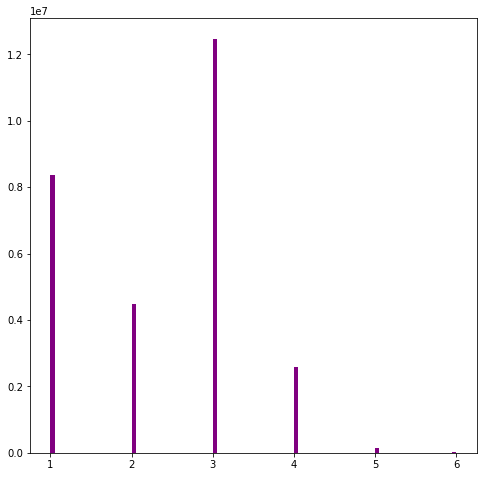

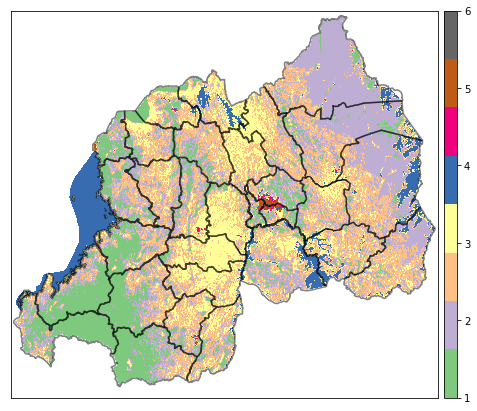

CPU times: user 6.56 s, sys: 2.84 s, total: 9.4 s
Wall time: 9.43 s


In [172]:
%%time
ep.hist(array_2000, figsize=(8, 8), bins=100)
plt.show()
fig, ax = plt.subplots(1, figsize = (8, 8))
image_hidden = ep.plot_bands(array_2000,
              cmap='Accent',
              extent=array_ext_2000,
              cbar=True,
             ax=ax,)
district_boundaries.boundary.plot( ax=ax, color='black', alpha=0.5)
plt.show()

In [103]:
%%time

villages = '/raw/nisr_administrative boundaries/Villages_boundaries.geojson'
districts = '/raw/nisr_administrative boundaries/district_boundaries.geojson'
stats = zonal_stats(dir_path+villages,
                     dir_path+fp_2000,
                   geojson_out=True,
                    categorical=True,
                    stats='majority'
                   )
village_landcover_2000 = []
for i in range(0,len(stats)):
    landcover_list = []
    for key, value in stats[i]['properties'].items():
        
        if key == 'code_vill_':
            village_code= value
        if key == 'majority':
            village_majority = value
        if isinstance(key,int):
            landcover = {key:value}
            landcover_list.append(landcover)
    village_landcover_2000.append({village_code:[village_majority,landcover_list]})

CPU times: user 1min 11s, sys: 13.3 s, total: 1min 25s
Wall time: 2min 37s


In [104]:
%%time
index = village_boundaries.code_vill_.tolist()
df_2000 = pd.DataFrame(np.nan, index=index, columns=['village_id','majority', '1', '2', '3', '4', '5', '6'])
for i in range(0,len(village_landcover_2000)):

    for i_d, val_list in (village_landcover_2000[i].items()):
        df_2000.loc[i_d,'village_id'] = i_d
        df_2000.loc[i_d,'majority'] = val_list[0]
        for dict_item in val_list[1]:          
            for key,value in dict_item.items():
                if key==1:
                    df_2000.loc[i_d,'1']=value
                if key==2:
                    df_2000.loc[i_d,'2']=value        
                if key==3:
                    df_2000.loc[i_d,'3']=value
                if key==4:
                    df_2000.loc[i_d,'4']=value            
                if key==5:
                    df_2000.loc[i_d,'5']=value            
                if key==6:
                    df_2000.loc[i_d,'6']=value            
df_2000['total_pixel_count'] = df_2000[['1', '2', '3', '4', '5', '6']].sum(axis=1)  
df_2000['Forestland_2000'] = round(df_2000['1']/df_2000['total_pixel_count']*100,1)
df_2000['Grassland_2000']  = round(df_2000['2']/df_2000['total_pixel_count']*100,1)
df_2000['Cropland_2000']   = round(df_2000['3']/df_2000['total_pixel_count']*100,1)
df_2000['Wetland_2000']    = round(df_2000['4']/df_2000['total_pixel_count']*100,1)
df_2000['Settlement_2000'] = round(df_2000['5']/df_2000['total_pixel_count']*100,1)
df_2000['Otherland_2000']  = round(df_2000['6']/df_2000['total_pixel_count']*100,1)

CPU times: user 3.28 s, sys: 15.6 ms, total: 3.29 s
Wall time: 3.3 s


In [105]:
df_2000.head()

,village_id,majority,1,2,3,4,5,6,total_pixel_count,Forestland_2000,Grassland_2000,Cropland_2000,Wetland_2000,Settlement_2000,Otherland_2000
11010102,11010102.0,5.0,NaN,NaN,NaN,NaN,28.0,NaN,28.0,NaN,NaN,NaN,NaN,100.0,NaN
11010103,11010103.0,5.0,NaN,NaN,NaN,NaN,84.0,NaN,84.0,NaN,NaN,NaN,NaN,100.0,NaN
11010104,11010104.0,5.0,NaN,NaN,NaN,NaN,14.0,NaN,14.0,NaN,NaN,NaN,NaN,100.0,NaN
11010105,11010105.0,5.0,NaN,NaN,NaN,NaN,36.0,NaN,36.0,NaN,NaN,NaN,NaN,100.0,NaN
11010106,11010106.0,5.0,NaN,NaN,NaN,NaN,15.0,NaN,15.0,NaN,NaN,NaN,NaN,100.0,NaN


### landcover 1990

In [201]:
# import tif file
fp_1990 = 'Rwanda_Landcover_1990_Scheme_I.tif'

with rio.open(dir_path+fp_1990) as dataset:
    array_1990 = dataset.read(1)
    crs_1990 = dataset.crs
    array_ext_1990 = plotting_extent(dataset)
    nodata_1990 = dataset.nodata
    array_1990 = np.where(array_1990 == nodata_1990, np.nan, array_1990)
    array_1990 = np.where(array_1990 == 0, np.nan, array_1990)
    transform_1990 = dataset.transform
    shape_1990 = dataset.shape

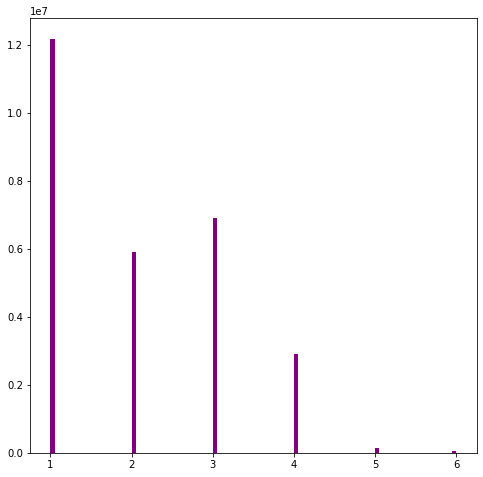

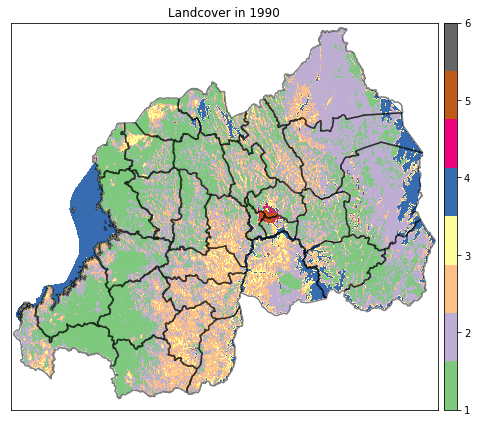

CPU times: user 5.94 s, sys: 1.33 s, total: 7.27 s
Wall time: 7.29 s


In [203]:
%%time
ep.hist(array_1990, figsize=(8, 8), bins=100)
plt.show()
fig, ax = plt.subplots(1, figsize = (8, 8))
image_hidden = ep.plot_bands(array_1990,
              cmap='Accent',
              extent=array_ext_1990,
              cbar=True,
             ax=ax,)
district_boundaries.boundary.plot( ax=ax, color='black', alpha=0.5)
ax.set_title('Landcover in 1990')
plt.show()

In [108]:
%%time

villages = '/raw/nisr_administrative boundaries/Villages_boundaries.geojson'
districts = '/raw/nisr_administrative boundaries/district_boundaries.geojson'
stats = zonal_stats(dir_path+villages,
                     dir_path+fp_1990,
                   geojson_out=True,
                    categorical=True,
                    stats='majority'
                   )
village_landcover_1990 = []
for i in range(0,len(stats)):
    landcover_list = []
    for key, value in stats[i]['properties'].items():
        
        if key == 'code_vill_':
            village_code= value
        if key == 'majority':
            village_majority = value
        if isinstance(key,int):
            landcover = {key:value}
            landcover_list.append(landcover)
    village_landcover_1990.append({village_code:[village_majority,landcover_list]})

CPU times: user 1min 10s, sys: 12.5 s, total: 1min 23s
Wall time: 2min 32s


In [109]:
%%time
index = village_boundaries.code_vill_.tolist()
df_1990 = pd.DataFrame(np.nan, index=index, columns=['village_id','majority', '1', '2', '3', '4', '5', '6'])
for i in range(0,len(village_landcover_1990)):

    for i_d, val_list in (village_landcover_1990[i].items()):
        df_1990.loc[i_d,'village_id'] = i_d
        df_1990.loc[i_d,'majority'] = val_list[0]
        for dict_item in val_list[1]:          
            for key,value in dict_item.items():
                if key==1:
                    df_1990.loc[i_d,'1']=value
                if key==2:
                    df_1990.loc[i_d,'2']=value        
                if key==3:
                    df_1990.loc[i_d,'3']=value
                if key==4:
                    df_1990.loc[i_d,'4']=value            
                if key==5:
                    df_1990.loc[i_d,'5']=value            
                if key==6:
                    df_1990.loc[i_d,'6']=value            
df_1990['total_pixel_count'] = df_1990[['1', '2', '3', '4', '5', '6']].sum(axis=1)  
df_1990['Forestland_1990'] = round(df_1990['1']/df_1990['total_pixel_count']*100,1)
df_1990['Grassland_1990']  = round(df_1990['2']/df_1990['total_pixel_count']*100,1)
df_1990['Cropland_1990']   = round(df_1990['3']/df_1990['total_pixel_count']*100,1)
df_1990['Wetland_1990']    = round(df_1990['4']/df_1990['total_pixel_count']*100,1)
df_1990['Settlement_1990'] = round(df_1990['5']/df_1990['total_pixel_count']*100,1)
df_1990['Otherland_1990']  = round(df_1990['6']/df_1990['total_pixel_count']*100,1)
df_1990.head()

CPU times: user 3.29 s, sys: 16.9 ms, total: 3.3 s
Wall time: 3.31 s


,village_id,majority,1,2,3,4,5,6,total_pixel_count,Forestland_1990,Grassland_1990,Cropland_1990,Wetland_1990,Settlement_1990,Otherland_1990
11010102,11010102.0,5.0,NaN,NaN,NaN,NaN,28.0,NaN,28.0,NaN,NaN,NaN,NaN,100.0,NaN
11010103,11010103.0,5.0,1.0,NaN,NaN,NaN,83.0,NaN,84.0,1.2,NaN,NaN,NaN,98.8,NaN
11010104,11010104.0,5.0,NaN,NaN,NaN,NaN,14.0,NaN,14.0,NaN,NaN,NaN,NaN,100.0,NaN
11010105,11010105.0,5.0,3.0,NaN,NaN,NaN,33.0,NaN,36.0,8.3,NaN,NaN,NaN,91.7,NaN
11010106,11010106.0,5.0,NaN,NaN,NaN,NaN,15.0,NaN,15.0,NaN,NaN,NaN,NaN,100.0,NaN


In [204]:

df= pd.concat([df_2015[['Forestland_2015','Grassland_2015','Cropland_2015','Wetland_2015','Settlement_2015','Otherland_2015']],
               df_2010[['Forestland_2010','Grassland_2010','Cropland_2010','Wetland_2010','Settlement_2010','Otherland_2010']],
               df_2000[['Forestland_2000','Grassland_2000','Cropland_2000','Wetland_2000','Settlement_2000','Otherland_2000']],
               df_1990[['Forestland_1990','Grassland_1990','Cropland_1990','Wetland_1990','Settlement_1990','Otherland_1990']],
               ], axis=1)


NameError: name 'df_2015' is not defined

In [164]:
categories = ['Forestland','Grassland','Cropland','Wetland','Settlement','Otherland']
dfs = [df_1990,df_2000,df_2010,df_2015]
years = [1990,2000,2010,2015]

dict_year = {}
for enum,df in enumerate(dfs):
    dict_cat = []
    for num,value in enumerate(categories):
        num_villages = df[df.majority==num+1]['majority'].count()
        dict_cat.append({value:num_villages})
    dict_year[years[enum]] = dict_cat
df_lc_years = pd.DataFrame(np.nan, index=[0,1,2,3],
                           columns=['year','Forestland','Grassland','Cropland','Wetland','Settlement','Otherland'])
df_lc_years.year = df_lc_years.year.astype(int)

In [169]:
i = 0
for i_d, val_list in (dict_year.items()):
    df_lc_years.loc[i,'year'] = i_d    
    for dict_item in val_list:
        for key,value in dict_item.items():
            if key=='Forestland':
                df_lc_years.loc[i,'Forestland']=value  
            if key=='Grassland':
                df_lc_years.loc[i,'Grassland']=value
            if key=='Cropland':
                df_lc_years.loc[i,'Cropland']=value    
            if key=='Wetland':
                df_lc_years.loc[i,'Wetland']=value  
            if key=='Settlement':
                df_lc_years.loc[i,'Settlement']=value
            if key=='Otherland':
                df_lc_years.loc[i,'Otherland']=value    
    
    i = i+1

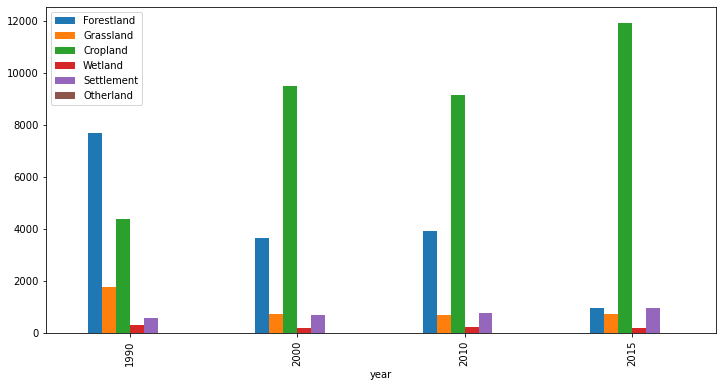

In [171]:
fig, ax = plt.subplots(1, figsize = (12, 6))
df_lc_years.plot(x="year", y=["Forestland", "Grassland",
                              "Cropland",'Wetland','Settlement','Otherland'], kind="bar",ax=ax)
plt.show()

In [174]:
village_boundaries.shape

(14815, 24)

In [179]:
dfs = [df_1990,df_2000,df_2010,df_2015]

In [180]:
dfs[0].head()

,village_id,majority,1,2,3,4,5,6,total_pixel_count,Forestland_1990,Grassland_1990,Cropland_1990,Wetland_1990,Settlement_1990,Otherland_1990
11010102,11010102.0,5.0,NaN,NaN,NaN,NaN,28.0,NaN,28.0,NaN,NaN,NaN,NaN,100.0,NaN
11010103,11010103.0,5.0,1.0,NaN,NaN,NaN,83.0,NaN,84.0,1.2,NaN,NaN,NaN,98.8,NaN
11010104,11010104.0,5.0,NaN,NaN,NaN,NaN,14.0,NaN,14.0,NaN,NaN,NaN,NaN,100.0,NaN
11010105,11010105.0,5.0,3.0,NaN,NaN,NaN,33.0,NaN,36.0,8.3,NaN,NaN,NaN,91.7,NaN
11010106,11010106.0,5.0,NaN,NaN,NaN,NaN,15.0,NaN,15.0,NaN,NaN,NaN,NaN,100.0,NaN


In [185]:
data = dfs[3]
pck_fp = dir_path+'/raw/nelga_land_cover/lc_2015.pck'
data.to_pickle(pck_fp)


## ELEVATION


In [8]:
# import tif file
fp_elevation = 'Rwanda_SRTM30meters.tif'

with rio.open(dir_path+fp_elevation) as dataset:
    array_elev = dataset.read(1)
    crs_elev = dataset.crs
    array_ext_elev = plotting_extent(dataset)
    nodata_elev = dataset.nodata
    array_elev = np.where(array_elev == nodata_elev, np.nan, array_elev)
    array_elev = np.where(array_elev == 0, np.nan, array_elev)
    transform_elev = dataset.transform
    shape_elev = dataset.shape
    units   = dataset.crs.linear_units
print(units)

unknown


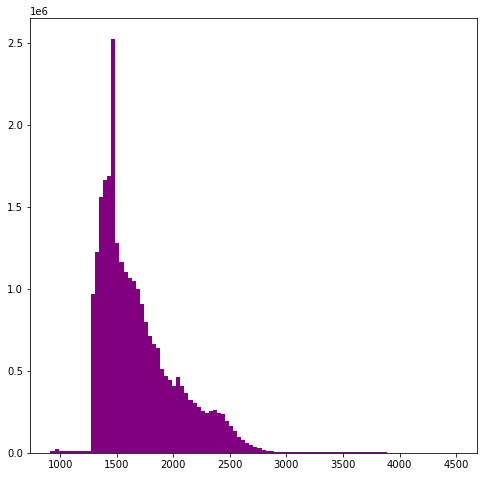

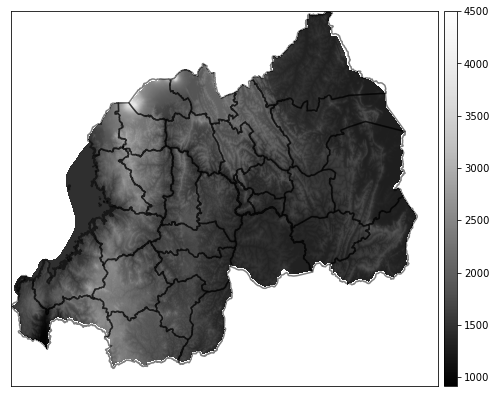

CPU times: user 5.35 s, sys: 1.2 s, total: 6.55 s
Wall time: 7.01 s


In [5]:
%%time
ep.hist(array_elev, figsize=(8, 8), bins=100)
plt.show()
fig, ax = plt.subplots(1, figsize = (8, 8))
image_hidden = ep.plot_bands(array_elev,
              # cmap='Accent',
              extent=array_ext_elev,
              cbar=True,
             ax=ax,)
district_boundaries.boundary.plot( ax=ax, color='black', alpha=0.5)
plt.show()

In [192]:
%%time

villages = '/raw/nisr_administrative boundaries/Villages_boundaries.geojson'

stats_elev = zonal_stats(dir_path+villages,
                     dir_path+fp_elevation,
                   geojson_out=True,
                    stats='mean'
                   )

CPU times: user 1min 11s, sys: 12.8 s, total: 1min 24s
Wall time: 2min 36s


In [202]:
village_elevation = []

for i in range(0,len(stats_elev)):
    elevation_list = []
    for key, value in stats_elev[i]['properties'].items():
        if key == 'code_vill_':
            village_code= value
        if key == 'mean':
            village_mean = value
    village_elevation.append({village_code:village_mean})


In [225]:
df_elev = pd.DataFrame(np.nan, index=index,columns=['village_id','mean_elevation'])
for i in range(0,len(village_elevation)):

    for i_d, value in (village_elevation[i].items()):
        df_elev.loc[i_d,'village_id'] = i_d
        df_elev.loc[i_d,'mean_elevation'] = value


In [288]:
df_elev.head()

,village_id,mean_elevation
11010102,11010102.0,1420.133333
11010103,11010103.0,1458.513514
11010104,11010104.0,1416.800000
11010105,11010105.0,1472.472222
11010106,11010106.0,1412.857143


In [289]:
data=df_elev
pck_fp = dir_path+'/raw/rcmrd_elevation/village_mean_elevation.pck'
data.to_pickle(pck_fp)

## Population

In [6]:
# import tif file
fp_popn = 'Rwanda_Population_Count_2015.tif'

with rio.open(dir_path+fp_popn) as dataset:
    array_popn = dataset.read(1)
    crs_popn = dataset.crs
    array_ext_popn = plotting_extent(dataset)
    nodata_popn = dataset.nodata
    array_popn = np.where(array_popn == nodata_popn, np.nan, array_popn)
    array_popn = np.where(array_popn == 0, np.nan, array_popn)
    transform_popn = dataset.transform
    shape_popn = dataset.shape

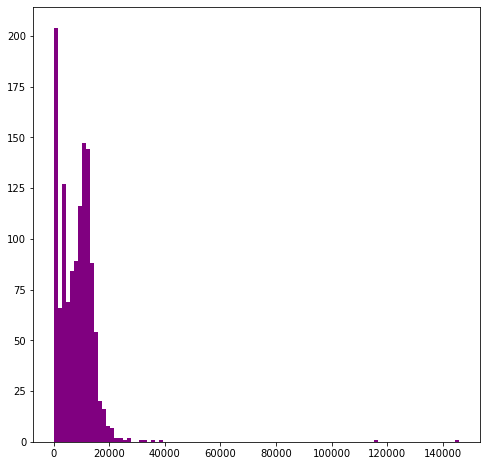

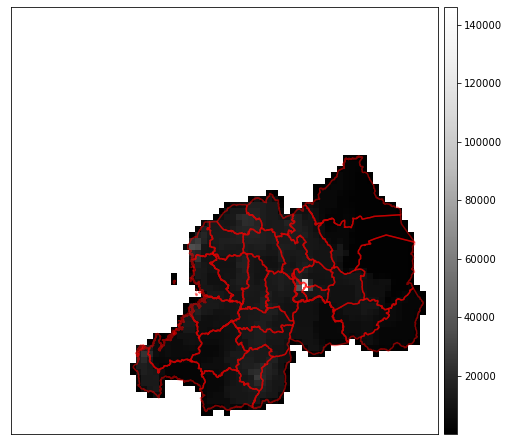

CPU times: user 649 ms, sys: 11 ms, total: 660 ms
Wall time: 670 ms


In [7]:
%%time
ep.hist(array_popn, figsize=(8, 8), bins=100)
plt.show()
fig, ax = plt.subplots(1, figsize = (8, 8))
image_hidden = ep.plot_bands(array_popn,

              extent=array_ext_popn,
              cbar=True,
             ax=ax,)
district_boundaries.boundary.plot( ax=ax, color='red', alpha=0.5)
plt.show()

In [293]:
%%time
stats_popn2015 = zonal_stats(dir_path+villages,
                     dir_path+fp_popn,
                   geojson_out=True,
                    all_touched=True,
                    stats='mean'
                   )

CPU times: user 1min 5s, sys: 11.8 s, total: 1min 17s
Wall time: 2min 24s


In [296]:
village_popn = []

for i in range(0,len(stats_popn2015)):
    popn_list = []
    for key, value in stats_popn2015[i]['properties'].items():
        if key == 'code_vill_':
            village_code= value
        if key == 'mean':
            village_mean = value
    village_popn.append({village_code:village_mean})

In [298]:
df_popn_2015 = pd.DataFrame(np.nan, index=index,columns=['village_id','mean_popn'])
for i in range(0,len(village_popn)):

    for i_d, value in (village_popn[i].items()):
        df_popn_2015.loc[i_d,'village_id'] = i_d
        df_popn_2015.loc[i_d,'mean_popn'] = value

In [299]:
df_popn_2015.mean_popn.nunique()

4544

In [300]:
data = df_popn_2015
pck_fp = dir_path+'/raw/rcmrd_population/village_mean_popn_2015.pck'
data.to_pickle(pck_fp)

# Asset Wealth

In [17]:
%%time
# import tif file
fp_asset = 'atlasAI/atlas-ai_proprietary_products_Asset-Wealth-1912m_0_08_RWA_2019.tiff'

with rio.open(dir_path+fp_asset) as dataset:
    array_asset = dataset.read(1)
    crs_asset = dataset.crs
    array_ext_asset = plotting_extent(dataset)
    nodata_asset = dataset.nodata
    array_asset = np.where(array_asset == nodata_asset, np.nan, array_asset)
    array_asset = np.where(array_asset == 0, np.nan, array_asset)
    transform_asset = dataset.transform
    shape_asset = dataset.shape
    units   = dataset.crs.linear_units
print(units)

metre
CPU times: user 4.88 ms, sys: 1.92 ms, total: 6.81 ms
Wall time: 49.7 ms


In [18]:
transform_asset

Affine(1912.0, 0.0, 3214072.0,
       0.0, -1912.0, -116632.0)

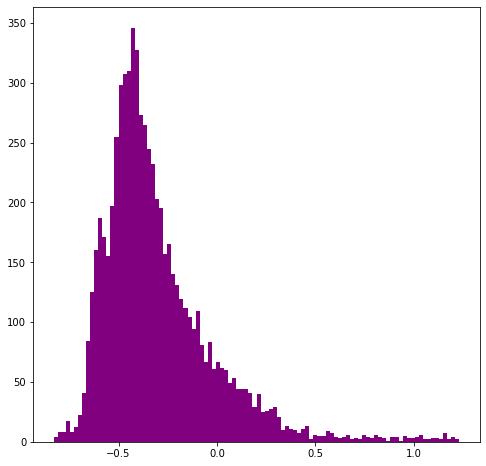

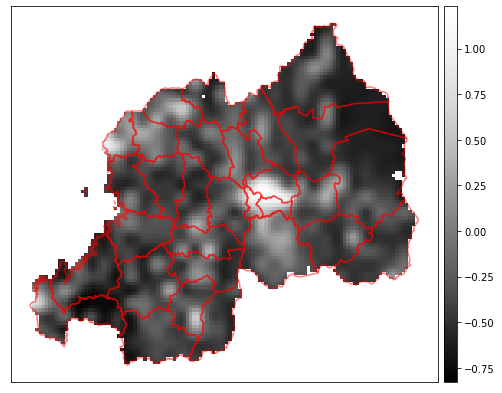

CPU times: user 1.29 s, sys: 83.1 ms, total: 1.38 s
Wall time: 1.54 s


In [19]:
%%time
crs = 3857
district_boundaries_3857  = district_boundaries.to_crs(crs)
village_boundaries_3857  = village_boundaries.to_crs(crs)
ep.hist(array_asset, figsize=(8, 8), bins=100)
plt.show()
fig, ax = plt.subplots(1, figsize = (8, 8))
image_hidden = ep.plot_bands(array_asset,

              extent=array_ext_asset,
              cbar=True,
             ax=ax,)
district_boundaries_3857.boundary.plot( ax=ax, color='red', alpha=0.5)
plt.show()

In [39]:
%%time
stats_asset = zonal_stats(village_boundaries_3857,
                     array_asset,
                    affine=transform_asset,
                   geojson_out=True,
                    all_touched=True,
                    stats='mean count'
                   )

CPU times: user 24.5 s, sys: 1.92 s, total: 26.4 s
Wall time: 26.5 s


In [40]:
%%time
village_assets = []

for i in range(0,len(stats_asset)):
    asset_list = []
    for key, value in stats_asset[i]['properties'].items():
        if key == 'code_vill_':
            village_code= value
        if key == 'mean':
            village_mean = value
    village_assets.append({village_code:village_mean})

CPU times: user 97.5 ms, sys: 2.96 ms, total: 100 ms
Wall time: 104 ms


In [41]:
%%time
index = village_boundaries.code_vill_.tolist()
df_AWI = pd.DataFrame(np.nan, index=index,columns=['village_id','mean_AWI'])
for i in range(0,len(village_assets)):

    for i_d, value in (village_assets[i].items()):
        df_AWI.loc[i_d,'village_id'] = i_d
        df_AWI.loc[i_d,'mean_AWI'] = value

CPU times: user 1.59 s, sys: 912 µs, total: 1.59 s
Wall time: 1.6 s


In [42]:
df_AWI.mean_AWI.nunique()

12949

In [43]:
data = df_AWI
pck_fp = dir_path+'AWI_2019.pck'
data.to_pickle(pck_fp)

## Spending

In [65]:
%%time
# import tif file
fp_spending = 'atlasAI/atlas-ai_proprietary_products_Spending-1912m_0_12_RWA_2019.tiff'

with rio.open(dir_path+fp_spending) as dataset:
    array_spending = dataset.read(1)
    crs_spending = dataset.crs
    array_ext_spending = plotting_extent(dataset)
    nodata_spending = dataset.nodata
    array_spending = np.where(array_spending == nodata_spending, np.nan, array_spending)
    array_spending = np.where(array_spending == 0, np.nan, array_spending)
    transform_spending = dataset.transform
    shape_spending = dataset.shape

CPU times: user 3.47 ms, sys: 1.96 ms, total: 5.43 ms
Wall time: 31.7 ms


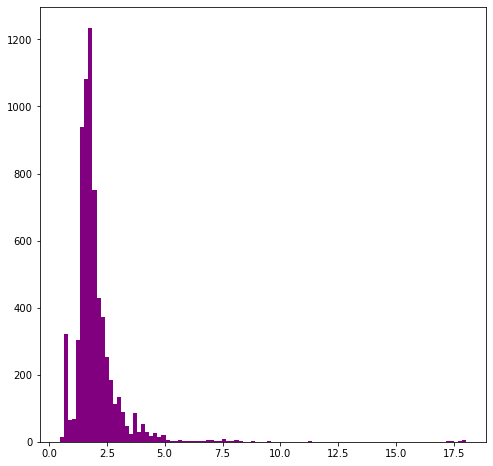

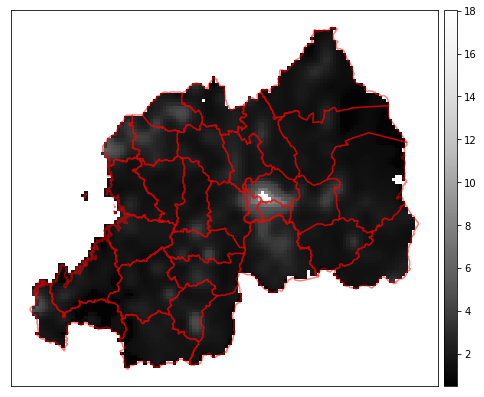

CPU times: user 658 ms, sys: 3.88 ms, total: 662 ms
Wall time: 671 ms


In [66]:
%%time
crs = 3857
district_boundaries_3857  = district_boundaries.to_crs(crs)
ep.hist(array_spending, figsize=(8, 8), bins=100)
plt.show()
fig, ax = plt.subplots(1, figsize = (8, 8))
image_hidden = ep.plot_bands(array_spending,

              extent=array_ext_spending,
              cbar=True,
             ax=ax,)
district_boundaries_3857.boundary.plot( ax=ax, color='red', alpha=0.5)
plt.show()

In [67]:
%%time
stats_spending = zonal_stats(village_boundaries_3857,
                     array_spending,
                    affine=transform_spending,
                   geojson_out=True,
                    all_touched=True,
                    stats='mean count'
                   )

CPU times: user 24.1 s, sys: 1.97 s, total: 26.1 s
Wall time: 26.1 s


In [68]:
%%time
village_spending = []

for i in range(0,len(stats_spending)):
    spending_list = []
    for key, value in stats_spending[i]['properties'].items():
        if key == 'code_vill_':
            village_code= value
        if key == 'mean':
            village_mean = value
    village_spending.append({village_code:village_mean})

CPU times: user 73.4 ms, sys: 768 µs, total: 74.2 ms
Wall time: 74.6 ms


In [69]:
%%time
index = village_boundaries.code_vill_.tolist()
df_spending = pd.DataFrame(np.nan, index=index,columns=['village_id','mean_spending'])
for i in range(0,len(village_spending)):

    for i_d, value in (village_spending[i].items()):
        df_spending.loc[i_d,'village_id'] = i_d
        df_spending.loc[i_d,'mean_spending'] = value

CPU times: user 1.57 s, sys: 1.86 ms, total: 1.57 s
Wall time: 1.57 s


In [70]:
df_spending.mean_spending.nunique()

12921

In [71]:
data = df_spending
pck_fp = dir_path+'spending_2019.pck'
data.to_pickle(pck_fp)

# Side work

In [74]:

village_ids = [33040201, 33040312, 33040307, 33040403, 33040412]

,objectid,code_vill_,code_prov,province,code_dist,district,code_sect,sector_1,code_cell_,prov_enlgi,...,area_km,source,capture,created_user,created_date,last_edited_user,last_edited_date,Shape__Area,Shape__Length,geometry
0,1,11010102,1,City of Kigali,11,Nyarugenge,1101,Gitega,110101,Kigali_City,...,0.027329,NISR,2012,None,None,None,None,27328.978161,785.081258,"POLYGON Z ((30.05217 -1.94732 0.00000, 30.0521..."
1,2,11010103,1,City of Kigali,11,Nyarugenge,1101,Gitega,110101,Kigali_City,...,0.072649,NISR,2012,None,None,None,None,72649.186582,1308.794821,"POLYGON Z ((30.05147 -1.94394 0.00000, 30.0511..."
2,3,11010104,1,City of Kigali,11,Nyarugenge,1101,Gitega,110101,Kigali_City,...,0.013936,NISR,2012,None,None,None,None,13936.183873,485.608236,"POLYGON Z ((30.05114 -1.94415 0.00000, 30.0511..."
3,4,11010105,1,City of Kigali,11,Nyarugenge,1101,Gitega,110101,Kigali_City,...,0.033358,NISR,2012,None,None,None,None,33358.036696,1152.362081,"POLYGON Z ((30.05468 -1.94683 0.00000, 30.0547..."
4,5,11010106,1,City of Kigali,11,Nyarugenge,1101,Gitega,110101,Kigali_City,...,0.013892,NISR,2012,None,None,None,None,13892.246047,527.309978,"POLYGON Z ((30.05195 -1.94681 0.00000, 30.0518..."


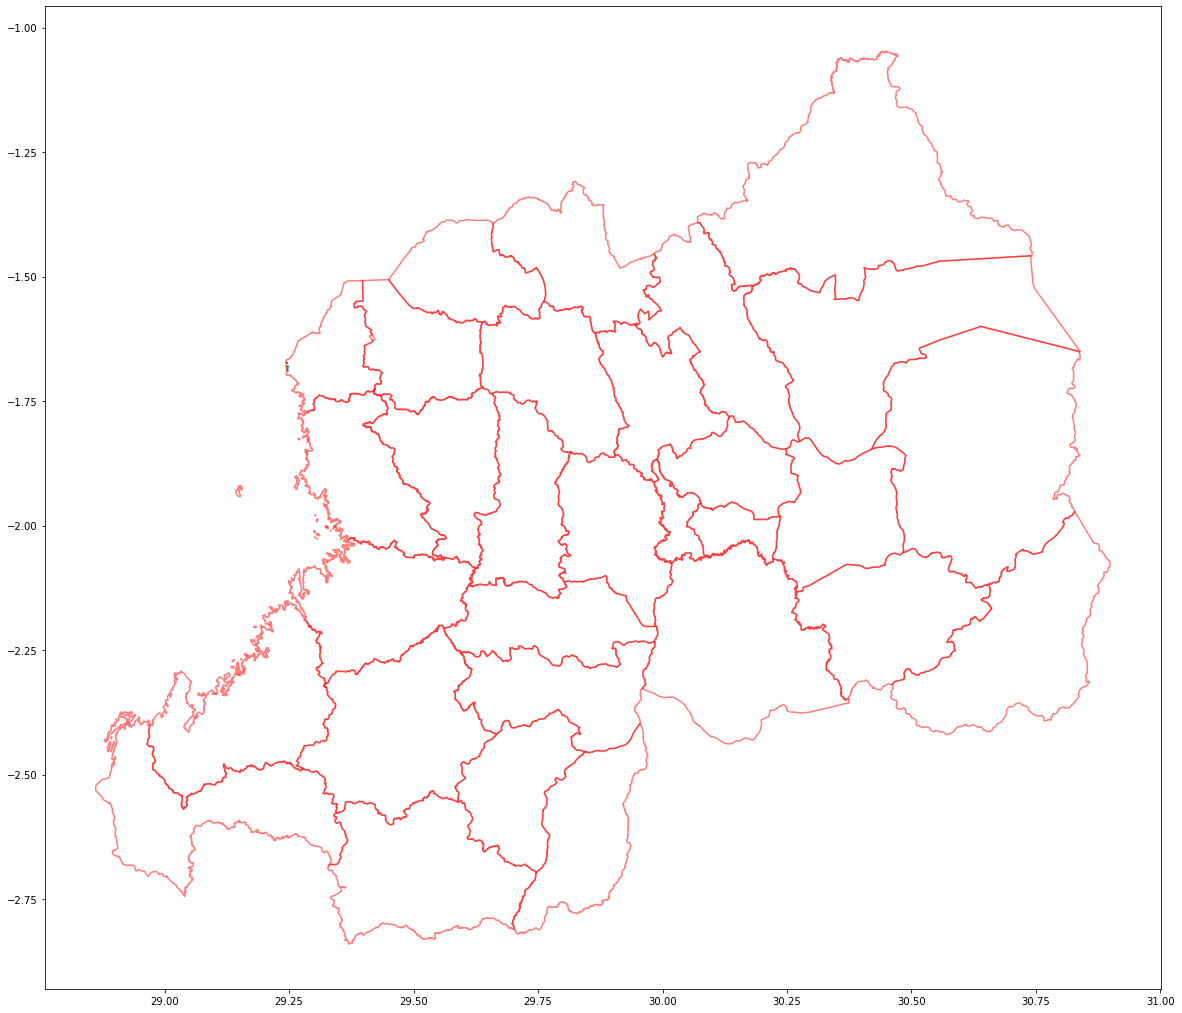

In [82]:
village_ids = [33040201, 33040312, 33040307, 33040403, 33040412]

fig, ax = plt.subplots(1, figsize = (20, 20))
district_boundaries.boundary.plot( ax=ax, color='red', alpha=0.5)
village_boundaries[village_boundaries.code_vill_.isin(village_ids)].plot(ax=ax)
# village_boundaries.plot(ax=ax)
plt.show()